In [377]:
%config Completer.use_jedi = False
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pprint
import healpy as hp
import reproject as rpj
from astropy.io import fits
from astropy.wcs import WCS
from tqdm import tnrange, tqdm_notebook
import pandas as pd

In [7]:
import pymongo
client = pymongo.MongoClient()  # default connection (ie, local)

In [8]:
mydb = client['racs']  # database

In [9]:
mycol = mydb['cubelets']  # collection; can also call as db['dwarfs']


In [10]:
# Quick check to confirm load
x = mycol.find_one()

x['q_file']

'/avatar/athomson/cubes/8585/RACS_test4_1.05_1049-31A/cutouts/image.restored.q.SB.8585.contcube.RACS_test4_1.05_1049-31A.cutout.J110106-314027.fits'

In [11]:
def cone_search(ra, dec, radius, collection=mycol, field='coords.loc'):
    
    scaling = wgs_scale(dec)
    meter_radius = radius * scaling
    lon, lat = ra-180., dec
    
    cursor = collection.find({'coords.loc': {
    '$nearSphere': { 
        '$geometry': { 'type': 'Point', 
                      'coordinates': [lon, lat]}, 
        '$maxDistance': meter_radius
    } } })
    
    return cursor

In [14]:
def wgs_scale(lat):
    # Get scaling to convert degrees to meters at a given geodetic latitude (declination)
    
    # Values from WGS 84
    a = 6378137.000000000000 # Semi-major axis of Earth
    b = 6356752.314140000000 # Semi-minor axis of Earth
    e = 0.081819190842600 # eccentricity
    angle = np.radians(1.0)
    
    # Compute radius of curvature along meridian (see https://en.wikipedia.org/wiki/Meridian_arc)
    rm = a * (1 - np.power(e, 2)) / np.power( ( (1 - np.power(e, 2) * np.power( np.sin(np.radians(lat)), 2) ) ), 1.5)
    
    # Compute length of arc at this latitude (meters/degree)
    arc = rm * angle
    return arc

In [420]:
ra = 165.1083333333333
dec = -29.95
rad = 0.5

cursor = cone_search(ra, dec, rad)
#df = pd.DataFrame(cursor)
#print(df)
#for doc in cursor:
#    pprint.pprint(doc,indent=1)

In [342]:
def printTable(myDict, colList=None):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
    If column names (colList) aren't specified, they will show in random order.
    Author: Thierry Husson - Use it as you want but don't blame me.
    """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] if item[col] is not None else '') for col in colList])
    colSize = [max(map(len,col)) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    myList.insert(1, ['-' * i for i in colSize]) # Seperating line
    for item in myList: print(formatStr.format(*item))

In [421]:
cursor.count()

/home/athomson/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """Entry point for launching an IPython kernel.


71

In [422]:
#hdu = fits.open(cursor[0]['i_file'], mode='denywrite')[0]
#wcs = WCS(hdu)

In [423]:
head = cursor[0]['header']
wcs_head = WCS(head).dropaxis(2)
new_head = wcs_head.to_header()
new_head['CRVAL1'] = ra
new_head['CRVAL2'] = dec
new_head['CDELT1'] *= 1
new_head['CDELT2'] *= 1
new_head['NAXIS'] = new_head['WCSAXES']
new_head['NAXIS1'] = int(abs(rad/new_head['CDELT1']))
new_head['NAXIS2'] = int(abs(rad/new_head['CDELT2']))
#new_head['NAXIS3'] = head['NAXIS3']

new_head['CRPIX1'] = new_head['NAXIS1']//2
new_head['CRPIX2'] = new_head['NAXIS2']//2

In [289]:
#i_array, footprint = rpj.reproject_interp(hdu, new_head)

In [322]:
#i_array.shape

In [396]:
def makelarge(args):
    new_head, cursor = args
    hdu = fits.open(cursor['i_file'], mode='denywrite')[0]
    temp_arr, footprint = rpj.reproject_interp((hdu.data.sum(axis=0),WCS(hdu).dropaxis(2)), new_head)
    return temp_arr

In [367]:
import schwimmbad
from multiprocessing import cpu_count

In [424]:
n_cores = cpu_count()
use_mpi = False

In [425]:
n_cores

56

In [ ]:
with schwimmbad.choose_pool(mpi=use_mpi, processes=n_cores) as pool:
    if use_mpi:
        output=list(pool.map(makelarge, [[new_head, cursor[i], i] for i in range(cursor.count())]))
    else:
        output=list(tqdm_notebook(pool.imap(makelarge, 
                                          [[new_head, cursor[i]] for i in range(cursor.count())]),
                     total = cursor.count()
                     ))
i_array = np.nanmean(np.array(output), axis=0)

Exception ignored in: <function _before_at_fork_weak_calls at 0x2b5482387510>
Traceback (most recent call last):
  File "/home/athomson/miniconda3/lib/python3.7/logging/__init__.py", line 265, in _before_at_fork_weak_calls
    _at_fork_weak_calls('acquire')
  File "/home/athomson/miniconda3/lib/python3.7/logging/__init__.py", line 257, in _at_fork_weak_calls
    method()
  File "/home/athomson/miniconda3/lib/python3.7/logging/__init__.py", line 854, in acquire
    self.lock.acquire()
KeyboardInterrupt: 
Ignoring exception from logging atfork <StreamHandler <stderr> (NOTSET)> release method: cannot release un-acquired lock
Ignoring exception from logging atfork <StreamHandler <stderr> (NOTSET)> release method: cannot release un-acquired lock
Ignoring exception from logging atfork <StreamHandler stderr (NOTSET)> release method: cannot release un-acquired lock
Ignoring exception from logging atfork <_StderrHandler stderr (WARNING)> release method: cannot release un-acquired lock
Ignoring 

Ignoring exception from logging atfork <StreamHandler <stderr> (NOTSET)> release method: cannot release un-acquired lock
Ignoring exception from logging atfork <StreamHandler stderr (NOTSET)> release method: cannot release un-acquired lock
Ignoring exception from logging atfork <_StderrHandler stderr (WARNING)> release method: cannot release un-acquired lock
Ignoring exception from logging atfork <StreamHandler stderr (NOTSET)> release method: cannot release un-acquired lock


In [384]:
#for i in tnrange(cursor.count()):
#    if i==0:
#        continue
#    else:
#        hdu = fits.open(cursor[i]['i_file'], mode='denywrite')[0]
#        temp_arr, footprint = rpj.reproject_interp(hdu, new_head)
#        i_array = np.nanmean(np.array([i_array,temp_arr]), axis=0)
#        #ind1 = np.where(np.isfinite(i_array))
#        #ind2 = np.where(np.isfinite(temp_arr))
#        #nan_count = npnp.isnan(i_array)
#        #nan

In [209]:
from matplotlib.colors import LogNorm

<IPython.core.display.Javascript object>


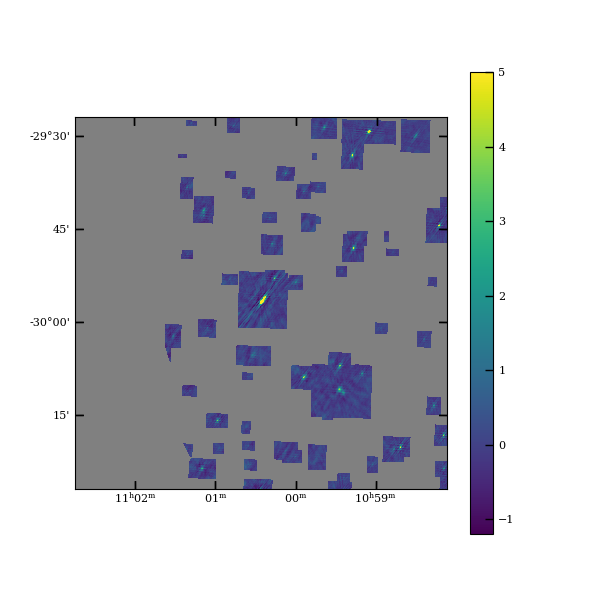

In [413]:
plt.figure()
ax = plt.subplot(projection=WCS(new_head))
im = ax.imshow(i_array, vmax=5)
plt.colorbar(im)

In [167]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [196]:
junk = SkyCoord(ra='11h00m26s', dec='-29d57m')
junk.ra.deg
junk.dec.deg

-29.95

In [53]:
NSIDE = 2048
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)

Approximate resolution at NSIDE 2048 is 0.029 deg


In [54]:
hpx_arr = np.ones_like(hp.nside2npix)*np.nan

In [55]:
array, foot = rpj.reproject_to_healpix(
                                        (hdu.data[0],wcs.dropaxis(2)),
                                        'g',
                                        nside=NSIDE)

In [56]:
all(np.isnan(array))

False

<IPython.core.display.Javascript object>


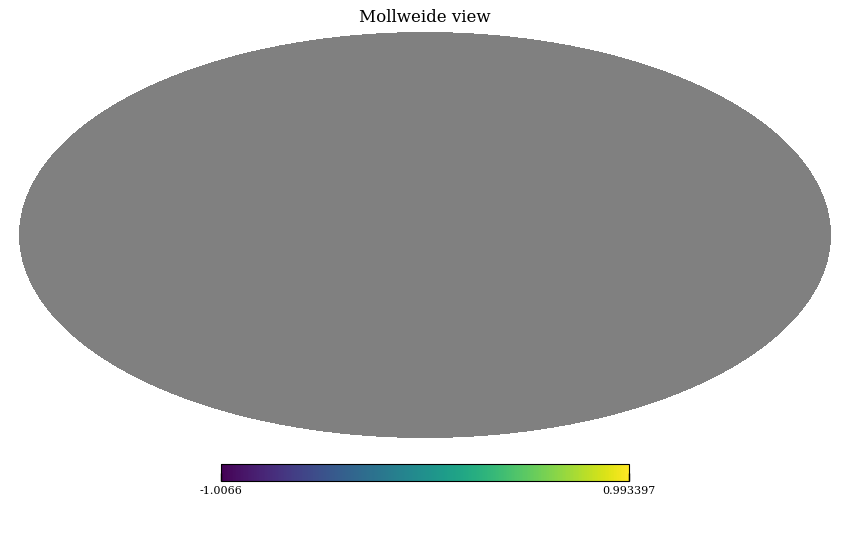

In [58]:
hp.mollview(array, xsize=10000)